In [1]:
%pylab inline
import numpy as np
np.set_printoptions(precision=6, linewidth=150)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import scipy.interpolate as interpolate
import scipy.integrate as integrate
import scipy.optimize as optimize

import lal
import lalsimulation

import pycbc.filter
import pycbc.types
import pycbc.psd

Populating the interactive namespace from numpy and matplotlib



In [2]:
sys.path.insert(0, '../src')

import waveform as wave
import waveformset as ws
import trainingset as train
import taylorf2
import gaussianprocessregression as gpr
import designofexperiment as doe
import lalwaveform
import plotparams
import greedy
import empiricalinterpolation as eim
import surrogate
import diagnostics
import fisher

import imp
imp.reload(wave)
imp.reload(ws)
imp.reload(train)
imp.reload(taylorf2)
imp.reload(gpr)
imp.reload(doe)
imp.reload(lalwaveform)
imp.reload(greedy)
imp.reload(eim)
imp.reload(surrogate)
imp.reload(diagnostics)
imp.reload(fisher)

import constants
imp.reload(constants)
from constants import *

# Test GPSurrogate class

In [3]:
# Bamp_filename = '../data/Bamp_p00015.hdf5'
# Bphase_filename = '../data/Bphase_p00015.hdf5'
# damp_gp_filename = '../data/amp_gp_p00015.hdf5'
# dphase_gp_filename = '../data/phase_gp_p00015.hdf5'
# sur = surrogate.GPSurrogate.load(Bamp_filename, Bphase_filename, damp_gp_filename, dphase_gp_filename)

# Bamp_filename = '../data/Bamp_p00015_n1056.hdf5'
# Bphase_filename = '../data/Bphase_p00015_n1056.hdf5'
# damp_gp_filename = '../data/amp_gp_p00015_n1056.hdf5'
# dphase_gp_filename = '../data/phase_gp_p00015_n1056.hdf5'
# sur = surrogate.GPSurrogate.load(Bamp_filename, Bphase_filename, damp_gp_filename, dphase_gp_filename)

Bamp_filename = '../data/Bamp_join_p00015.hdf5'
Bphase_filename = '../data/Bphase_join_p00015.hdf5'
damp_gp_filename = '../data/amp_gp_join_p00015.hdf5'
dphase_gp_filename = '../data/phase_gp_join_p00015.hdf5'
sur = surrogate.GPSurrogate.load(Bamp_filename, Bphase_filename, damp_gp_filename, dphase_gp_filename)

In [4]:
testset_rand = ws.HDF5WaveformSet('../data/h_test_set_rand_p00015_n1000.hdf5')
#testset_uni = ws.HDF5WaveformSet('../data/h_test_set_uniform_p00015.hdf5')

[  6.874134e-01  -5.689529e-01   4.473011e-01   6.046346e+03   4.190074e+03]


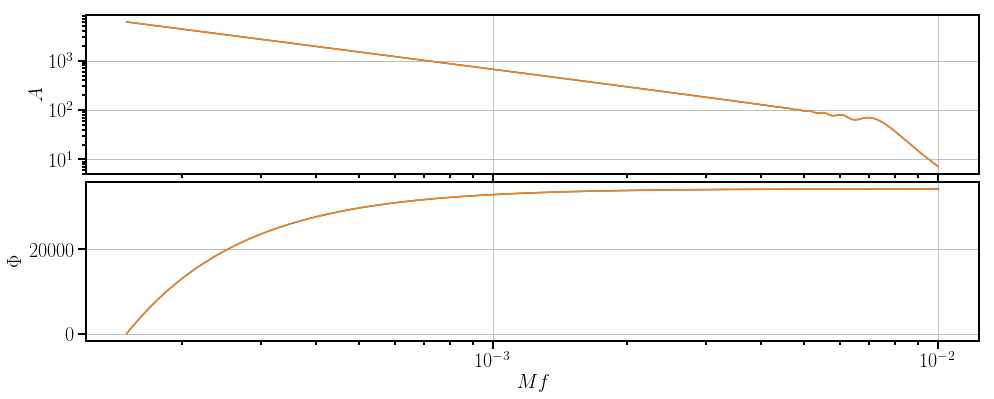

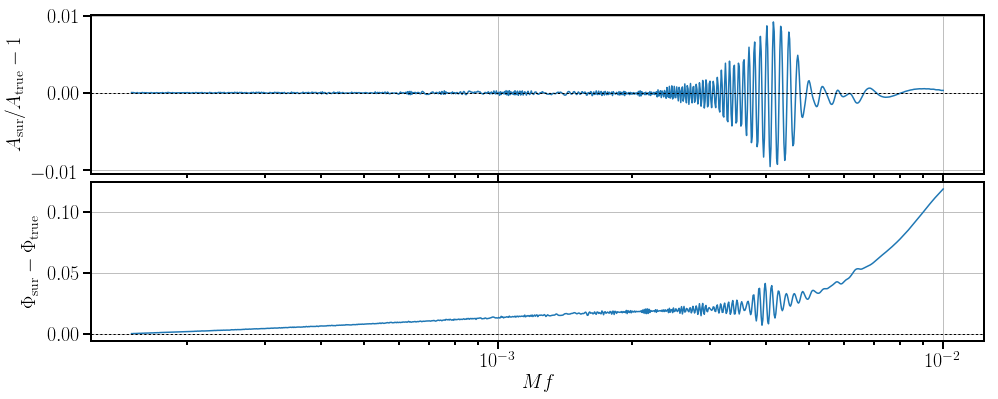

In [5]:
i = 99
params = testset_rand.get_waveform(i, data='parameters')
print params

h_true = testset_rand[i]
h_sur = sur.geometric_waveform(params)

# Plot h_true and h_sur
fig, (ax1, ax2) = wave.plot_waveforms_fd([h_sur, h_true])
ax1.set_yscale('log')
ax1.set_ylabel(r'$A$')
ax2.set_ylabel(r'$\Phi$')
ax2.set_xlabel(r'$Mf$')
ax1.grid()
ax2.grid()

# Plot error
fig, (ax1, ax2) = wave.plot_waveform_difference_fd(h_sur, h_true)
ax1.set_ylabel(r'$A_{\rm sur}/A_{\rm true} - 1$')
ax2.set_ylabel(r'$\Phi_{\rm sur} - \Phi_{\rm true}$')
ax2.set_xlabel(r'$Mf$')
ax1.grid()
ax2.grid()

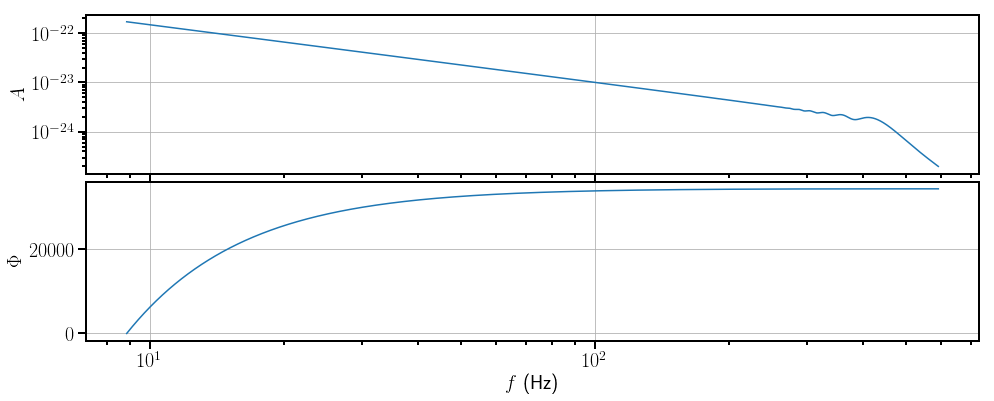

In [6]:
q, spin1z, spin2z, lambda1, lambda2 = params
mass2 = 1.4
mass1 = mass2/q
distance = 100.

h_phys = sur.physical_waveform_zero_inclination(
    mass1=mass1, mass2=mass2, 
    spin1z=spin1z, spin2z=spin2z, 
    lambda1=lambda1, lambda2=lambda2,
    distance=distance)

fig, (ax1, ax2) = wave.plot_waveforms_fd([h_phys])
ax1.set_yscale('log')
ax1.set_ylabel(r'$A$')
ax2.set_ylabel(r'$\Phi$')
ax2.set_xlabel(r'$f$ (Hz)')
ax1.grid()
ax2.grid()

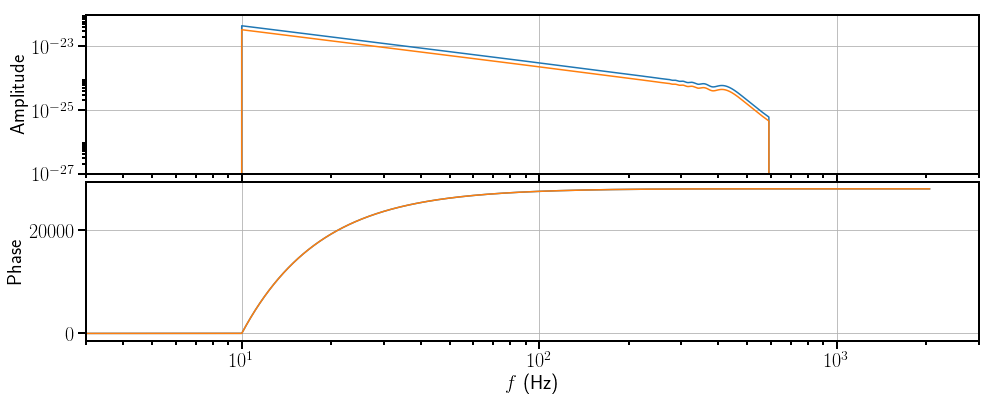

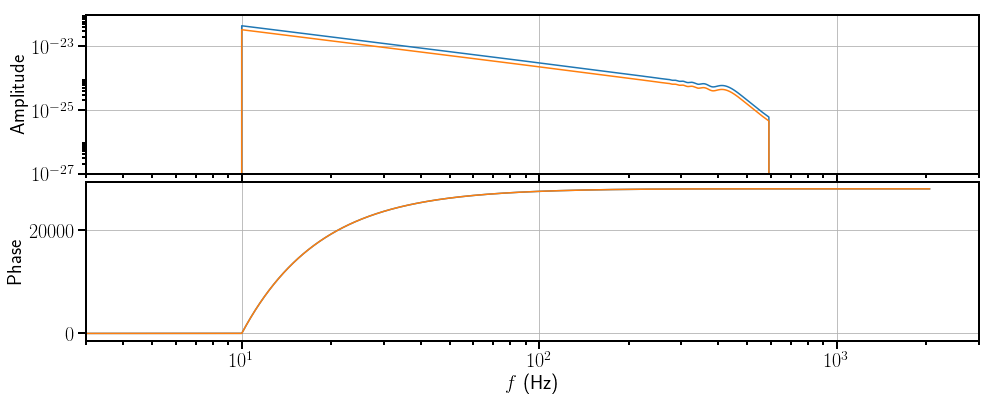

In [7]:
q, spin1z, spin2z, lambda1, lambda2 = params
mass2 = 1.4
mass1 = mass2/q
distance = 100.
inclination = 1.1
f_min = 10.
f_max = 2048.
delta_f = 3.0e-4

freq, hp_lal, hc_lal = sur.physical_waveform_lal(
    mass1=mass1, mass2=mass2, 
    spin1z=spin1z, spin2z=spin2z, 
    lambda1=lambda1, lambda2=lambda2,
    distance=distance, inclination=inclination, 
    f_min=f_min, f_max=f_max, delta_f=delta_f, 
    f_ref=None, phi_ref=None)

hp_pycbc, hc_pycbc = sur.physical_waveform_pycbc(
    mass1=mass1, mass2=mass2, 
    spin1z=spin1z, spin2z=spin2z, 
    lambda1=lambda1, lambda2=lambda2,
    distance=distance, inclination=inclination, 
    f_min=f_min, f_max=f_max, delta_f=delta_f, 
    f_ref=None, phi_ref=None)

hp_lal = wave.Waveform.from_complex(freq, hp_lal)
hc_lal = wave.Waveform.from_complex(freq, hc_lal)

hp_pycbc = wave.Waveform.from_complex(np.array(hp_pycbc.sample_frequencies), np.array(hp_pycbc))
hc_pycbc = wave.Waveform.from_complex(np.array(hc_pycbc.sample_frequencies), np.array(hc_pycbc))

fig, (ax1, ax2) = wave.plot_waveforms_fd([hp_lal, hc_lal])
ax1.set_yscale('log')
ax1.grid()
ax2.grid()
ax1.set_ylim(1.0e-27, 1.0e-22)
ax2.set_xlim(3., 3000.)
ax2.set_xlabel(r'$f$ (Hz)')

fig, (ax1, ax2) = wave.plot_waveforms_fd([hp_pycbc, hc_pycbc])
ax1.set_yscale('log')
ax1.grid()
ax2.grid()
ax1.set_ylim(1.0e-27, 1.0e-22)
ax2.set_xlim(3., 3000.)
ax2.set_xlabel(r'$f$ (Hz)')

# Mismatch calculations

In [8]:
def geometric_waveform_to_physical_hp_hc(h_geom, mtot, distance, inclination, f_min, f_max, delta_f):
    """Convert a frequency-domain Waveform object to ~h_+ and ~h_x in physical units (Hz^{-1})
    using the same convention as lalsimulation:
        -Uniformly spaced frequencies in [0, f_max).
        -Data is zero below max(f_min, first data point in h_geom) and
        zero above min(f_max, last data point in h_geom).
    """
    h_phys = wave.dimensionless_to_physical_freq(h_geom, mtot, distance)
    
    # Initialize arrays. The output is zero below f_min.
    freq = np.arange(0.0, f_max, delta_f)
    h_plus = np.zeros(len(freq), dtype=complex)
    h_cross = np.zeros(len(freq), dtype=complex)
    
    # Find the nonzero elements
    f_min_nonzero = max(f_min, h_phys.x[0])
    f_max_nonzero = min(f_max, h_phys.x[-1])
    # Can't compare arrays with 'and'. Have to use bitwise '&' instead.
    i_nonzero = np.where((freq>=f_min_nonzero) & (freq<=f_max_nonzero))
    freq_nonzero = freq[i_nonzero]
    
    # Amplitude and phase in the nonzero region
    amp = h_phys.interpolate('amp')(freq_nonzero)
    phase = h_phys.interpolate('phase')(freq_nonzero)
    
    inc_plus = 0.5*(1.0+np.cos(inclination)**2)
    inc_cross = np.cos(inclination)
    
    h_plus[i_nonzero] = inc_plus * 0.5*amp*np.exp(1.0j*phase)
    h_cross[i_nonzero] = inc_cross * 0.5*amp*np.exp(1.0j*(phase+np.pi/2.0))
    
    return freq, h_plus, h_cross


def mismatch(h1, h2, f_min):
    """Mismatch between h1, h2, with a low-frequency cutoff of f_min.
    
    Parameters
    ----------
    h1, h2 : pycbc FrequencySeries
    f_min : float
    """
    flen = len(h1)
    delta_f = h1.delta_f
    psd = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, f_min)
    
    # Mismatch
    return 1.0-pycbc.filter.match(h1, h2, psd=psd, low_frequency_cutoff=f_min)[0]


def surrogate_mismatch(i, f_min, f_max, delta_f=0.01, mass2=1.0, distance=100., inclination=0):
    """
    """
    
    h_true = testset_rand[i]
    params = testset_rand.get_waveform(i, data='parameters')
    
    q, spin1z, spin2z, lambda1, lambda2 = params
    mass1 = mass2/q
    f_ref = f_min
    phi_ref = 0.

    #print mass1, mass2, spin1z, spin2z, lambda1, lambda2
    # Generate true waveform in physical units from testset waveform
    mtot = mass1 + mass2
    f, hp, hc = geometric_waveform_to_physical_hp_hc(
        h_true, mtot, distance, inclination, f_min, f_max, delta_f)
    hp_true_phys, hc_true_phys = surrogate.physical_to_pycbc_frequency_series(f, hp, hc)
    
    # Generate surrogate waveform
    hp_sur_phys, hc_sur_phys = sur.physical_waveform_pycbc(
        mass1=mass1, mass2=mass2, 
        spin1z=spin1z, spin2z=spin2z, 
        lambda1=lambda1, lambda2=lambda2, 
        delta_f=delta_f, f_min=f_min, f_max=f_max, f_ref=f_ref, 
        distance=distance, inclination=inclination, phi_ref=phi_ref)
    
    return params, mismatch(hp_true_phys, hp_sur_phys, f_min)

In [9]:
f_min = 16.
f_max = 4096.
mass2 = 1.0

params_list_10 = []
mismatch_list_10 = []
for i in range(len(testset_rand)):
    #for i in range(5):
    print i,
    params, mm = surrogate_mismatch(i, f_min, f_max, delta_f=0.01, mass2=mass2, distance=100., inclination=0)
    params_list_10.append(params)
    mismatch_list_10.append(mm)
    
params_mm_10 = np.concatenate((np.array(params_list_10).T, np.array([mismatch_list_10]))).T
#np.savetxt('params_mm_10.txt', params_mm_10)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

In [10]:
f_min = 16.
f_max = 4096.
mass2 = 2.0

params_list_20 = []
mismatch_list_20 = []
for i in range(len(testset_rand)):
    #for i in range(5):
    print i,
    params, mm = surrogate_mismatch(i, f_min, f_max, delta_f=0.01, mass2=mass2, distance=100., inclination=1.2)
    params_list_20.append(params)
    mismatch_list_20.append(mm)
    
params_mm_20 = np.concatenate((np.array(params_list_20).T, np.array([mismatch_list_20]))).T
#np.savetxt('params_mm_20.txt', params_mm_20)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

In [11]:
np.max(params_mm_10[:, 5]), np.max(params_mm_20[:, 5])

(0.0013425677547856951, 0.00080629050632607946)

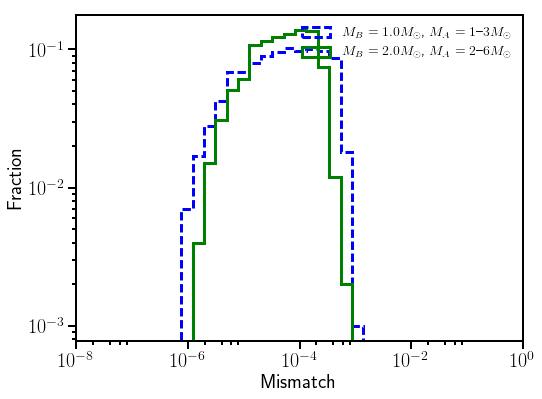

In [12]:
fig, axes = plt.subplots(1, figsize=(8, 6))

Nsamp = len(params_mm_10)
axes.hist(params_mm_10[:, 5], bins=np.logspace(-10, 0, 50), weights=np.ones(Nsamp)/Nsamp, histtype='step', 
          ls='--', lw=3, color='blue', alpha=1.0, label=r'$M_B=1.0M_\odot$, $M_A=1$--$3M_\odot$')

Nsamp = len(params_mm_20)
axes.hist(params_mm_20[:, 5], bins=np.logspace(-10, 0, 50), weights=np.ones(Nsamp)/Nsamp, histtype='step', 
          ls='-', lw=3, color='green', alpha=1.0, label=r'$M_B=2.0M_\odot$, $M_A=2$--$6M_\odot$')

axes.set_xscale("log")
axes.set_yscale("log")
axes.set_xlim([1.0e-8, 1.0e-0])
#axes.set_ylim([1, 1.0e8])
axes.set_xlabel(r'Mismatch')
axes.set_ylabel(r'Fraction')
axes.legend(loc='upper right', frameon=False)
#fig.savefig('/home/bdlackey/public_html/ROM/mismatchhist.pdf', format='pdf', transparent=True, bbox_inches='tight')

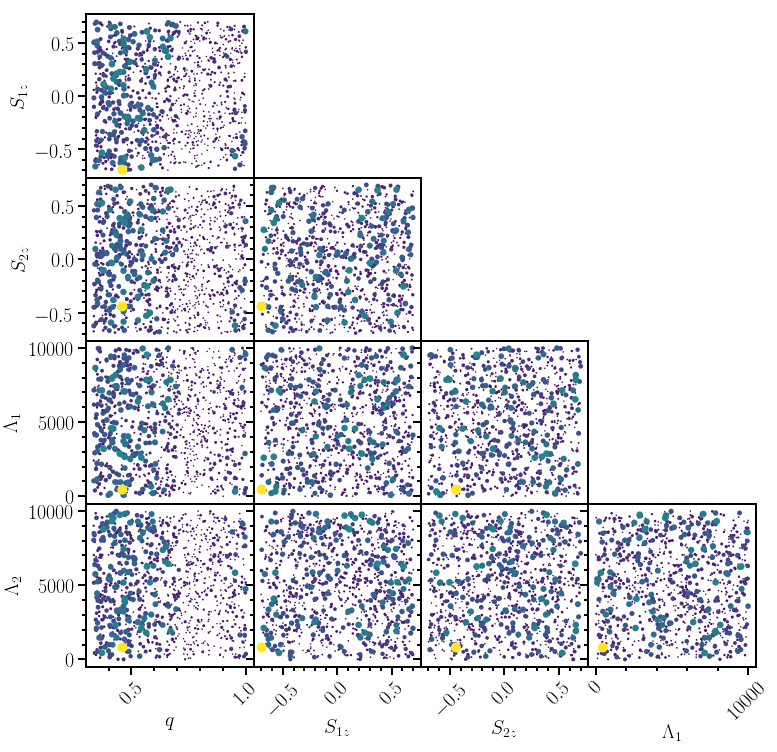

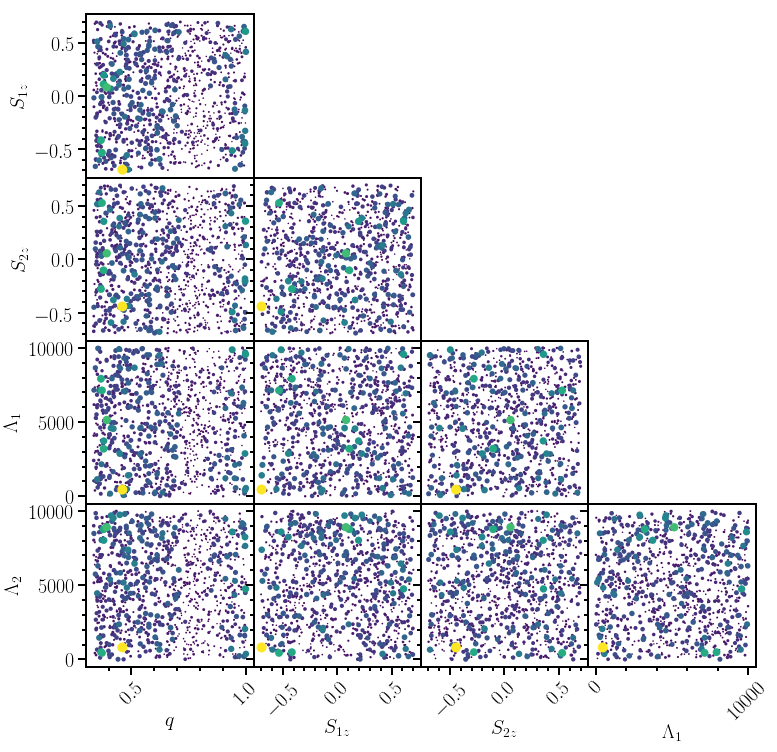

In [13]:
labels = [r'$q$', r'$S_{1z}$', r'$S_{2z}$', r'$\Lambda_1$', r'$\Lambda_2$']

params = params_list_10
error = mismatch_list_10
#print len(error[error>=0.1])
fig, ax = diagnostics.error_2d_triangle_plot(params, error, labels, threshold=None, figsize=(10, 10))

params = params_list_20
error = mismatch_list_20
fig, ax = diagnostics.error_2d_triangle_plot(params, error, labels, threshold=None, figsize=(10, 10))

# Amplitude and phase errors

In [14]:
# def fractional_amp_error(dlnamp_sur, dlnamp_true):
#     """Calculate A_sur/A_true-1 given dlnA_sur and dlnA_true,
#     where dlnA_sur = lnA_sur-lnA_ref and dlnA_true = lnA_true-lnA_ref.
#     """
#     error = np.exp(dlnamp_sur-dlnamp_true)-1.0
#     return np.max(np.abs(error))

def fractional_amp_error(amp_sur, amp_true):
    """Calculate A_sur / A_true - 1.
    """
    error = amp_sur/amp_true - 1.0
    return np.max(np.abs(error))

# def phase_error(dphase_sur, dphase_true):
#     """Calculate Phi_sur-Phi_true given dPhi_sur and dPhi_true,
#     where dPhi_sur = Phi_sur-Phi_ref and Phi_true = Phi_true-Phi_ref.
#     """
#     error = dphase_sur-dphase_true
#     return np.max(np.abs(error))

def phase_error(phase_sur, phase_true):
    """Calculate Phi_sur - Phi_true.
    """
    error = phase_sur - phase_true
    return np.max(np.abs(error))

In [15]:
params_rand = []
amp_err = []
phase_err = []
for i in range(len(testset_rand)):
    print i,
    hrand = testset_rand[i]
    params = testset_rand.get_waveform(i, data='parameters')
    hsur = sur.geometric_waveform(params)
    
    mfhigh = 0.020
    dlnamp_sur = hsur.amp[hsur.x<=mfhigh]
    dlnamp_true = hrand.amp[hrand.x<=mfhigh]
    dphase_sur = hsur.phase[hsur.x<=mfhigh]
    dphase_true = hrand.phase[hrand.x<=mfhigh]
    
    ae = fractional_amp_error(dlnamp_sur, dlnamp_true)
    pe = phase_error(dphase_sur, dphase_true)
    
    params_rand.append(params)
    amp_err.append(ae)
    phase_err.append(pe)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

In [16]:
np.max(amp_err), np.max(phase_err)

(0.029374465103249481, 1.048040295332612)

In [17]:
i_ampmax = np.array(amp_err).argmax()
i_phasemax = np.array(phase_err).argmax()

In [18]:
params_rand[i_ampmax], params_rand[i_phasemax]

(array([  3.454752e-01,  -3.700448e-01,  -3.075830e-01,   1.944943e+03,   2.010306e+03]),
 array([  4.513172e-01,   6.801949e-01,   1.360530e-01,   8.043021e+03,   3.205947e+03]))

[  4.513172e-01   6.801949e-01   1.360530e-01   8.043021e+03   3.205947e+03]
[ 0.451317  0.680195  0.136053  0.        0.      ]


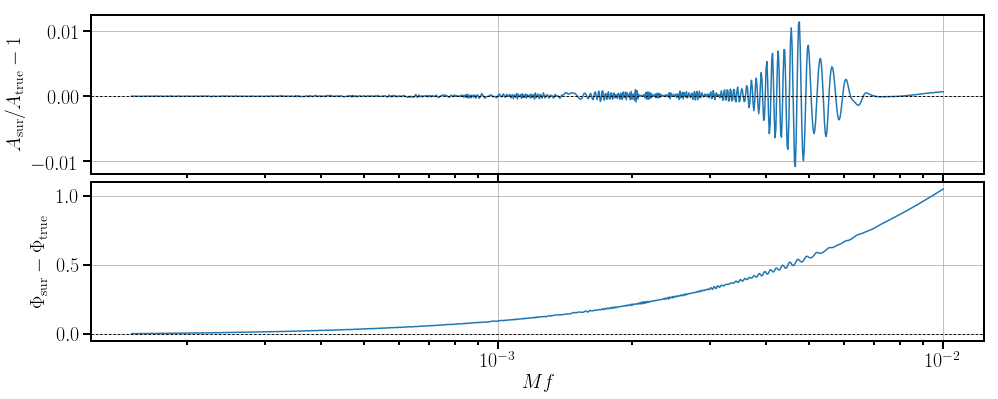

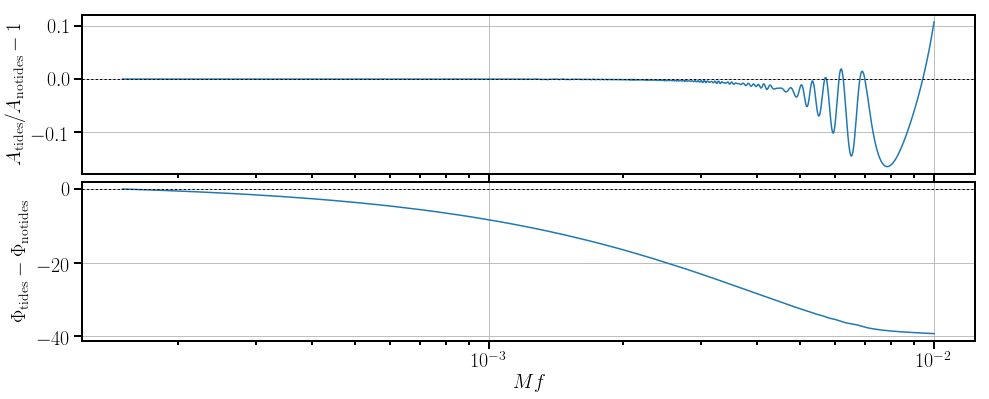

In [19]:
#i = i_ampmax
i = i_phasemax

hrand = testset_rand[i]
params = testset_rand.get_waveform(i, data='parameters')
print params
hsur = sur.geometric_waveform(params)

fig, (ax1, ax2) = wave.plot_waveform_difference_fd(hsur, hrand)
ax1.set_ylabel(r'$A_{\rm sur}/A_{\rm true} - 1$')
ax2.set_ylabel(r'$\Phi_{\rm sur} - \Phi_{\rm true}$')
ax2.set_xlabel(r'$Mf$')
ax1.grid()
ax2.grid()

params_notides = np.array([params[0], params[1], params[2], 0., 0.])
print params_notides
hsur_notides = sur.geometric_waveform(params_notides)
fig, (ax1, ax2) = wave.plot_waveform_difference_fd(hsur, hsur_notides)
ax1.set_ylabel(r'$A_{\rm tides}/A_{\rm no tides} - 1$')
ax2.set_ylabel(r'$\Phi_{\rm tides} - \Phi_{\rm notides}$')
ax2.set_xlabel(r'$Mf$')
ax1.grid()
ax2.grid()

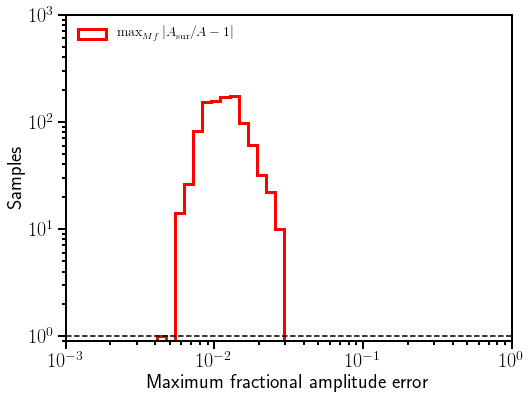

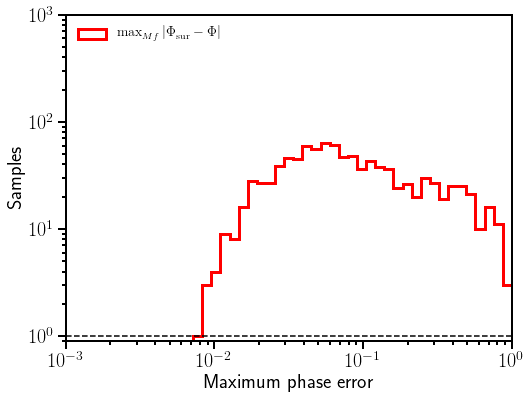

In [20]:
fig, ax1 = plt.subplots(figsize=(8, 6))
ax1.hist(amp_err, bins=np.logspace(-3, 0, 50), histtype='step', 
          ls='-', lw=3, color='red', alpha=1.0, label=r'$\max_{Mf}|A_{\rm sur}/A-1|$')
ax1.axhline(1.0, c='k', ls='--')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim([1.0e-3, 1.0])
ax1.set_ylim([0.9, 1000])
ax1.set_xlabel('Maximum fractional amplitude error')
ax1.set_ylabel('Samples')
ax1.legend(loc='upper left', frameon=False)

fig, ax2 = plt.subplots(figsize=(8, 6))
ax2.hist(phase_err, bins=np.logspace(-3, 0, 50), histtype='step', 
          ls='-', lw=3, color='red', alpha=1.0, label=r'$\max_{Mf}|\Phi_{\rm sur}-\Phi|$')
ax2.axhline(1.0, c='k', ls='--')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlim([1.0e-3, 1.0])
ax2.set_ylim([0.9, 1000])
ax2.set_xlabel('Maximum phase error')
ax2.set_ylabel('Samples')
ax2.legend(loc='upper left', frameon=False)

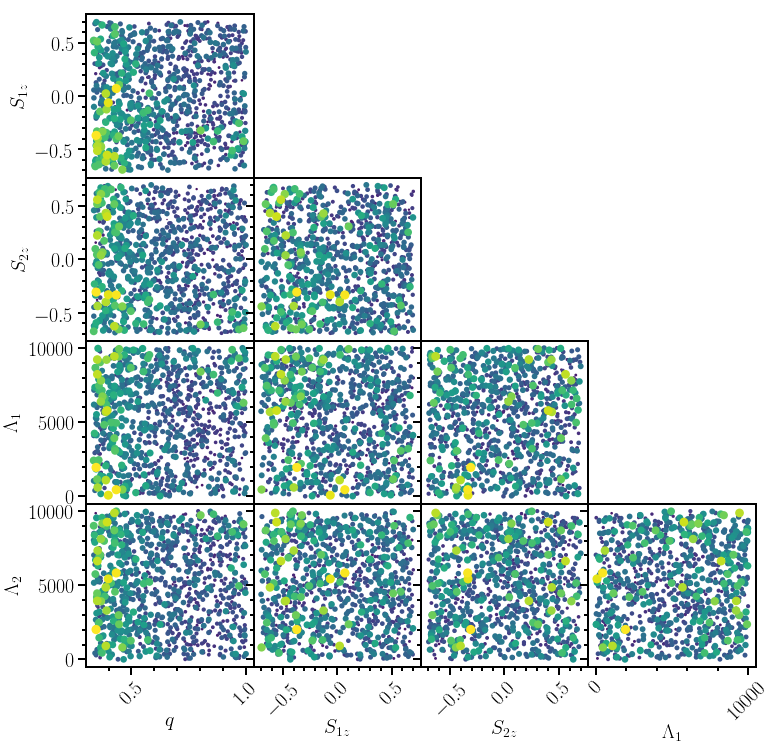

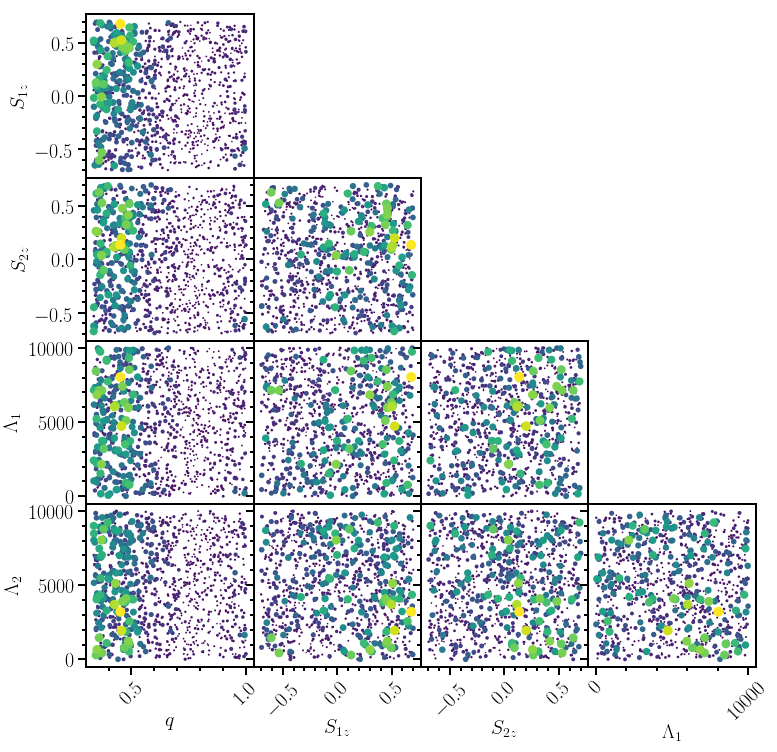

In [21]:
labels = [r'$q$', r'$S_{1z}$', r'$S_{2z}$', r'$\Lambda_1$', r'$\Lambda_2$']
params = params_rand

error = np.array(amp_err)
#print len(error[error>=0.1])
fig, ax = diagnostics.error_2d_triangle_plot(params, error, labels, threshold=None, figsize=(10, 10))

error = phase_err
#print len(error[error>=1.0])
fig, ax = diagnostics.error_2d_triangle_plot(params, error, labels, threshold=None, figsize=(10, 10))

# Compare errors to tidal phase contribution

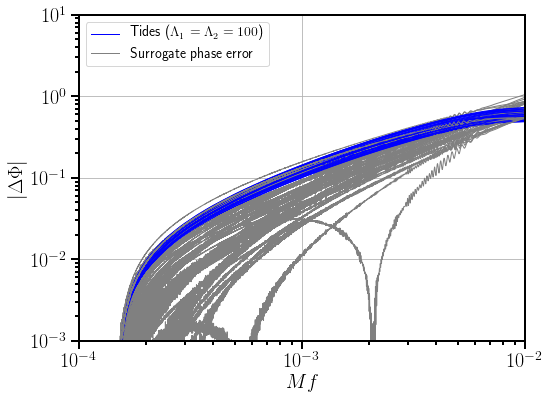

In [22]:
phase_error_indices_sorted_decrease = np.flip(np.argsort(np.array(phase_err)), 0)

lam = 100.

fig, ax = plt.subplots(figsize=(8, 6))

j = 0
#for i in range(0, len(testset_rand), 10):
for i in phase_error_indices_sorted_decrease[:50]:
    hrand = testset_rand[i]
    params = testset_rand.get_waveform(i, data='parameters')
    hsur = sur.geometric_waveform(params)
    
    mfs = hsur.x
    error = np.abs(hsur.phase-hrand.phase)

    params_lam0 = np.array([params[0], params[1], params[2], 0., 0.])
    hsur_lam0 = sur.geometric_waveform(params_lam0)
    
    params_lam = np.array([params[0], params[1], params[2], lam, lam])
    hsur_lam = sur.geometric_waveform(params_lam)
    
    tidal_effect = np.abs(hsur_lam.phase-hsur_lam0.phase)
    
    if j==0:
        ax.plot(mfs, tidal_effect, ls='-', c='b', lw=1, label='Tides ($\Lambda_1=\Lambda_2=100$)')
    else:
        ax.plot(mfs, tidal_effect, ls='-', c='b', lw=1)
        
    if j==0:
        ax.plot(mfs, error, c='gray', lw=1, label='Surrogate phase error')
    else:
        ax.plot(mfs, error, c='gray', lw=1)
    
    j = 1

ax.set_ylabel(r'$|\Delta\Phi|$')
ax.set_xlabel(r'$Mf$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(0.0001, 0.01)
ax.set_ylim(1.0e-3, 10.)
ax.grid()
ax.legend(loc='upper left')

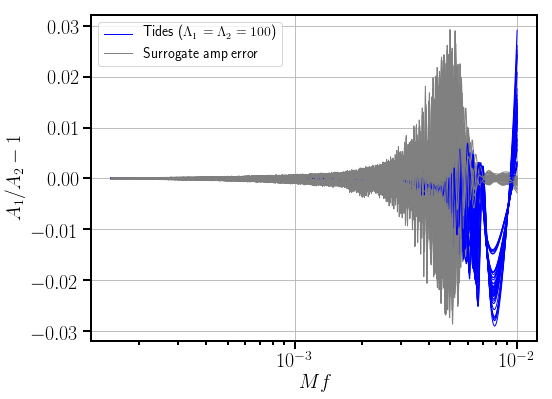

In [23]:
amp_error_indices_sorted_decrease = np.flip(np.argsort(np.array(amp_err)), 0)

lam = 1000.

fig, ax = plt.subplots(figsize=(8, 6))

j = 0
#for i in range(0, len(testset_rand), 10):
for i in amp_error_indices_sorted_decrease[:50]:
    hrand = testset_rand[i]
    params = testset_rand.get_waveform(i, data='parameters')
    hsur = sur.geometric_waveform(params)
    
    mfs = hsur.x
    error = hsur.amp/hrand.amp - 1.

    params_lam0 = np.array([params[0], params[1], params[2], 0., 0.])
    hsur_lam0 = sur.geometric_waveform(params_lam0)
    
    params_lam = np.array([params[0], params[1], params[2], lam, lam])
    hsur_lam = sur.geometric_waveform(params_lam)
    
    tidal_effect = hsur_lam.amp/hsur_lam0.amp - 1.
    
    if j==0:
        ax.plot(mfs, tidal_effect, ls='-', c='b', lw=1, label='Tides ($\Lambda_1=\Lambda_2=100$)')
    else:
        ax.plot(mfs, tidal_effect, ls='-', c='b', lw=1)
    
    if j==0:
        ax.plot(mfs, error, c='gray', lw=1, label='Surrogate amp error')
    else:
        ax.plot(mfs, error, c='gray', lw=1)
        
    j = 1

ax.set_ylabel(r'$A_{\rm 1}/A_{\rm 2} - 1$')
ax.set_xlabel(r'$Mf$')
ax.set_xscale('log')
#ax.set_yscale('log')
#ax.set_xlim(0.0001, 0.01)
#ax.set_ylim(1.0e-3, 10.)
ax.grid()
ax.legend(loc='upper left')

In [27]:
def tidal_phase(mf, params):
    q, s1, s2, lambda1, lambda2 = params
    eta = q / (1. + q)**2
    tlam = taylorf2.lamtilde_of_eta_lam1_lam2(eta, lambda1, lambda2)
    dtlam = taylorf2.deltalamtilde_of_eta_lam1_lam2(eta, lambda1, lambda2)
    
    print eta, tlam, dtlam
    
    a00 = 3.0/(128.0*eta)
    a50 = -39.0*tlam/2.0
    a60 = -3115.0*tlam/64.0 + 6595.0*np.sqrt(1.0-4.0*eta)*dtlam/364.0

    x = (np.pi*mf)**(2.0/3.0)
    
    phi = a00*x**(-5.0/2.0)*(a50*x**5 + a60*x**6)
    return phi

In [29]:
#i = i_ampmax
i = i_phasemax
#i = 10

hrand = testset_rand[i]
params = testset_rand.get_waveform(i, data='parameters')
hsur = sur.geometric_waveform(params)

params100 = np.array([params[0], params[1], params[2], 100., 100.])
hsur100 = sur.geometric_waveform(params100)
# print params100


params_notides = np.array([params[0], params[1], params[2], 0., 0.])
print params_notides
hsur_notides = sur.geometric_waveform(params_notides)

[ 0.363686  0.68769  -0.147548  0.        0.      ]


0.195568059001 13890.6176979 -3374.99305024


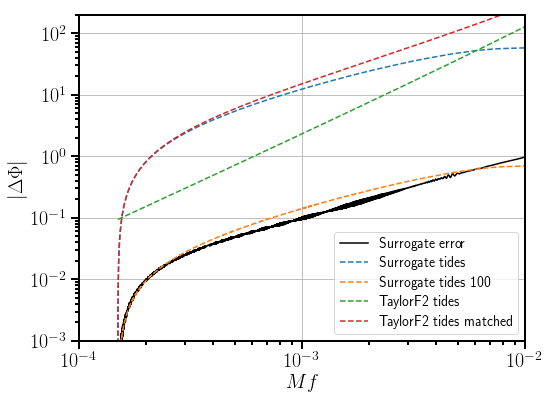

In [30]:
mfs = hsur.x
sur_tidal = hsur.phase - hsur_notides.phase
f2_tidal = tidal_phase(mfs, params)

delta_tidal = f2_tidal-sur_tidal
slope = (delta_tidal[100]-delta_tidal[0])/(mfs[100]-mfs[0])
delta_tidal_shift = f2_tidal - slope*mfs
delta_tidal_shift -= delta_tidal_shift[0]
         
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(hsur.x, np.abs(hsur.phase-hrand.phase), c='k', label='Surrogate error')
ax.plot(hsur.x, np.abs(hsur.phase-hsur_notides.phase), ls='--', label='Surrogate tides')
ax.plot(hsur.x, np.abs(hsur100.phase-hsur_notides.phase), ls='--', label='Surrogate tides 100')
ax.plot(hsur.x, np.abs(f2_tidal), ls='--', label='TaylorF2 tides')
ax.plot(hsur.x, np.abs(delta_tidal_shift), ls='--', label='TaylorF2 tides matched')
ax.set_ylabel(r'$|\Delta\Phi|$')
ax.set_xlabel(r'$Mf$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(0.0001, 0.01)
ax.set_ylim(1.0e-3, 200.)
#ax.set_ylim(0., 1.)
ax.grid()
ax.legend()

0.25 100.0 -0.0
0.25 300.0 -0.0
0.25 1000.0 -0.0


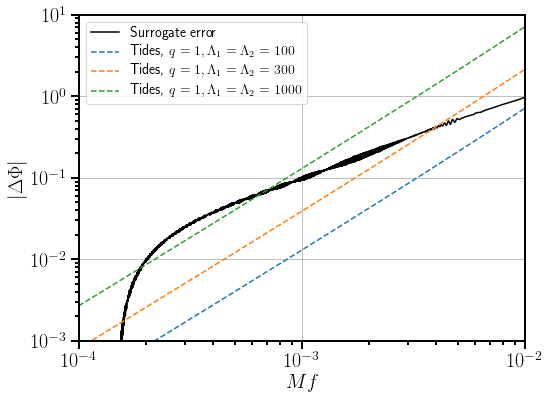

In [31]:
mfs = np.logspace(-4, -2, 100)

q=1.
tidal_100 = tidal_phase(mfs, [q, 0., 0., 100, 100])
tidal_300 = tidal_phase(mfs, [q, 0., 0., 300, 300])
tidal_1000 = tidal_phase(mfs, [q, 0., 0., 1000, 1000])

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(hsur.x, np.abs(hsur.phase-hrand.phase), c='k', label='Surrogate error')
ax.plot(mfs, np.abs(tidal_100), ls='--', label='Tides, $q=1, \Lambda_1=\Lambda_2=100$')
ax.plot(mfs, np.abs(tidal_300), ls='--', label='Tides, $q=1, \Lambda_1=\Lambda_2=300$')
ax.plot(mfs, np.abs(tidal_1000), ls='--', label='Tides, $q=1, \Lambda_1=\Lambda_2=1000$')

ax.set_ylabel(r'$|\Delta\Phi|$')
ax.set_xlabel(r'$Mf$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(0.0001, 0.01)
ax.set_ylim(1.0e-3, 10.)
#ax.set_ylim(0., 1.)
ax.grid()
ax.legend(loc='upper left')